In [1]:
# Use autoreload extension so agent definition is always up to date.
# Src: https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

import os
import time
from collections import deque

import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from unityagents import UnityEnvironment

import BananaAgent as Agents

sns.set_style()


In [2]:
# TODO: Check if Banana is available
# Load environment and get initial brain
env_train_mode = True # Sets the simulation slower and shows the screen with the agent

env = UnityEnvironment("Banana/Banana.x86_64", no_graphics=env_train_mode)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Initialize environment for use of the agent
env_info = env.reset(train_mode=env_train_mode)[brain_name]
action_space = brain.vector_action_space_size
state_space = env_info.vector_observations.size

print(f"Action space: {action_space}")
print(f"State space: {state_space}")


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Action space: 4
State space: 37


In [3]:
def do_episode(environment, agent):
    """Performs a single episode using the given environment and agent

    Args:
        environment (env): Environment that will perform the simulation
        agent (Agent): Agent that will traverse the environment

    Returns:
        (float, int): Total score and steps of the episode
    """
    episode_score = 0
    env_info = env.reset(train_mode=env_train_mode)[brain_name]

    # Start the agent
    state = env_info.vector_observations[0]
    next_action = agent.start(state)

    # Take the first action
    env_info = env.step(next_action)[brain_name]

    while not env_info.local_done[0]:
        # Take a step from the agent
        reward = env_info.rewards[0]
        episode_score += reward
        state = env_info.vector_observations[0]

        next_action = agent.step(reward, state, learn=False)

        # Perform action
        env_info = env.step(next_action)[brain_name]
    
    # Register last reward to the agent
    reward = env_info.rewards[0]
    episode_score += reward
    agent.end(reward)

    return episode_score


def do_experiment(environment, agent, episodes, print_every):
    """Performs an experiment on the given agent.

    Args:
        environment (any): Environment to use
        agent (Agent): Agent that follows the "Agent" interface
        episodes (int): Amount of episodes to perform
        print_every (int): How often to print the episode information

    Returns:
        (array_like, array_like): Scores and times that the agent took per episode
    """
    scores = np.zeros(episodes)
    times = np.zeros(episodes)

    for i in range(episodes):
        start_time = time.time()
        scores[i] = do_episode(environment, agent)
        times[i] = time.time() - start_time

        # Log data
        ep = i+1
        
        if ep % print_every == 0:
            print(f"{agent.agent_name()} :: ({ep}/{episodes}) AVG {np.average(scores[max(0, i-print_every):ep])}")
    
    return scores, times

BananaAgentDouble :: (10/100) AVG 15.9
BananaAgentDouble :: (20/100) AVG 16.545454545454547
BananaAgentDouble :: (30/100) AVG 16.363636363636363
BananaAgentDouble :: (40/100) AVG 14.454545454545455
BananaAgentDouble :: (50/100) AVG 14.636363636363637
BananaAgentDouble :: (60/100) AVG 15.727272727272727
BananaAgentDouble :: (70/100) AVG 17.818181818181817
BananaAgentDouble :: (80/100) AVG 16.363636363636363
BananaAgentDouble :: (90/100) AVG 14.272727272727273
BananaAgentDouble :: (100/100) AVG 16.272727272727273


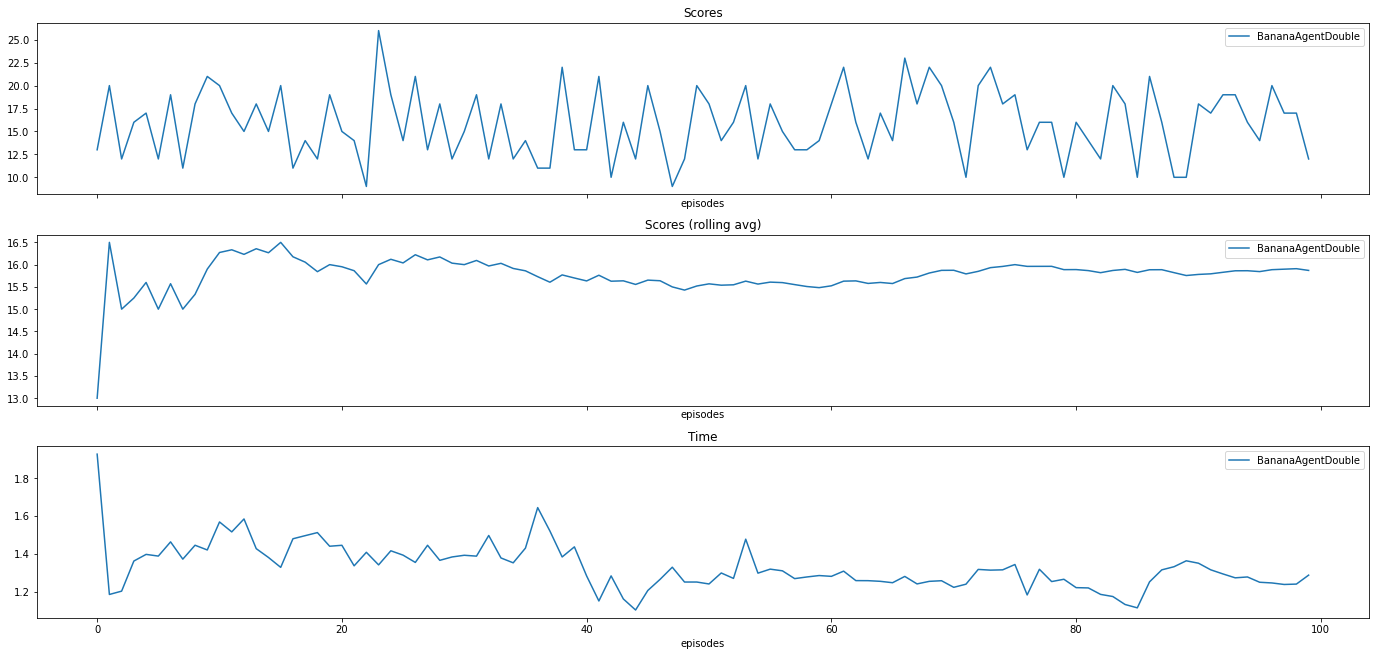

In [4]:

# Perform each episode of the training
figure, axis = plt.subplots(3, 1, figsize=(19, 9), constrained_layout=True, sharex="all")
axis[0].set_title("Scores")
axis[0].set_xlabel("episodes")
axis[1].set_title("Scores (rolling avg)")
axis[1].set_xlabel("episodes")
axis[2].set_title("Time")
axis[2].set_xlabel("episodes")

average_window = 100
episodes = 100
print_every = 10

# agent = create_agent(state_space, action_space, **wandb.config)
agent = torch.load("agents/BananaAgentDouble-1lalhy3r.pt")
# Do experiment
scores, times = do_experiment(env, agent, episodes, print_every)
agent_name = agent.agent_name()

# Plot the statistics
x = np.arange(episodes)
sns.lineplot(x=x, y=scores, label=agent_name, ax=axis[0])

avg = [np.average(scores[max(0, n-average_window):n+1]) for n in range(episodes)]
sns.lineplot(x=x, y=avg, label=agent_name, ax=axis[1])

sns.lineplot(x=x, y=times, label=agent_name, ax=axis[2])

plt.show()

    


In [5]:
# Close environment
env.close()